In [5]:
import torch
import torch.nn.functional as F

from helper import look

import pandas as pd

import svgling

# Data

In [6]:
LETTERS = "ABCD"
N = len(LETTERS)

freqs = torch.randint(1, 100, size=(N,))
probs = freqs / sum(freqs)
model = dict(zip(LETTERS, map(float, probs)))

pd.DataFrame(zip(LETTERS, map(int, freqs), map(float, probs)), 
             columns=["word", "freq", "prob"])

,word,freq,prob
0,A,21,0.164062
1,B,53,0.414062
2,C,40,0.312500
3,D,14,0.109375


# Hufmann build tree

Letters sorted by probability: B C A D

Resulting tree: (B ((D A) C))

('B', (('D', 'A'), 'C'))


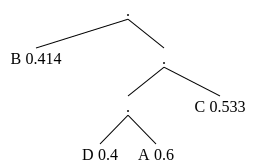

{'B': 0.4140625, (('D', 'A'), 'C'): 0.5859375, ('D', 'A'): 0.4666666666666667, 'C': 0.5333333333333333, 'D': 0.4, 'A': 0.6}


,w,freq,prob,code,bits
0,A,21,0.164062,1 0 1,0.492188
1,B,53,0.414062,0,0.414062
2,C,40,0.312500,1 1,0.625000
3,D,14,0.109375,1 0 0,0.328125


In [22]:
stack = sorted(model, key=model.get, reverse=True)

look("Letters sorted by probability:"," ".join(ch for ch in stack))

def compute_prob(node, model):
    if isinstance(node, str):
        return model[node]
    else:
        return sum(compute_prob(subnode, model) 
                   for subnode in node)

tree = stack.pop()
p_tree = model[tree]
while stack:
    node = stack.pop()
    p_node = model[node]

    if p_node < p_tree:
        tree = (node, tree)
    else:
        tree = (tree, node)
    p_tree += p_node

look("Resulting tree:",str(tree).replace(",", "").replace("'", ""))
#svgling.draw_tree(tree)
print(tree)
svgling.draw_tree(("S", ("NP", ("D", "the"), ("N", "elephant")), ("VP", ("V", "saw"), ("NP", ("D", "the"), ("N", "rhinoceros")))))

codes = {}
branch_probs = {}

stack = [(tree, [])]
while stack:
    node, path = stack.pop()
    if isinstance(node, str):
        codes[node] = path
    elif len(node) == 1:
        branch_probs[node[0]] = 1.

        stack.append((node[0], path + [1]))
    else:
        left, right = node
        p_left = compute_prob(left, model)
        p_right = compute_prob(right, model)
        
        branch_probs[left] = p_left / (p_left + p_right)
        branch_probs[right] = p_right / (p_left + p_right)

        stack.append((left, path + [0]))
        stack.append((right, path + [1]))


display(svgling.draw_tree((".", f"B {branch_probs['B']:.3}", (".", (".", f"D {branch_probs['D']:.3}", f"A {branch_probs['A']:.3}"), f"C {branch_probs['C']:.3}"))))

print(branch_probs)
pd.DataFrame([(w, 
               freqs[i].item(), 
               probs[i].item(), 
               " ".join(map(str, codes[w])),
               probs[i].item() * len(codes[w]))
              for i, w in enumerate(LETTERS)], 
              columns=["w", "freq", "prob", "code", "bits"])



